# 🏷️ Auto-Labelling Images using Roboflow AutoDistill

This notebook demonstrates **automatic dataset labeling** using **Roboflow AutoDistill**.

Auto-labelling uses a **pretrained foundation model** to generate annotations
for unlabeled images, dramatically reducing manual effort.


## 🧭 Notebook Flow
1. Why Auto-Labelling
2. Environment Setup
3. Install AutoDistill
4. Choose a Teacher Model
5. Run Auto-Labelling
6. Inspect Generated Annotations
7. Best Practices


## 1️⃣ Why Auto-Labelling?
- Manual annotation is slow and expensive
- Foundation models already understand generic objects
- AutoDistill transfers this knowledge to your dataset


## 2️⃣ Environment Setup
Enable GPU: `Runtime → Change runtime type → GPU`

In [ ]:
import torch
print('CUDA available:', torch.cuda.is_available())
print('GPU:', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None')

CUDA available: True
GPU: Tesla T4


## 3️⃣ Install AutoDistill & Dependencies

In [ ]:
!pip install -q autodistill autodistill-grounding-dino supervision roboflow opencv-python pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 27.3 MB/s eta 0:00:00


## 4️⃣ Prepare Unlabelled Images
Place your raw images inside a folder named `unlabelled_images/`.

## 5️⃣ Choose a Teacher Model (GroundingDINO)

In [ ]:
from autodistill_grounding_dino import GroundingDINO

base_model = GroundingDINO(
    ontology={
        "pothole": "pothole",
        "road_damage": "road damage"
    }
)

Importing from timm.models.layers is deprecated, please import via timm.layers


trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## 6️⃣ Run Auto-Labelling

In [ ]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology

# Re-initializing base_model with the correct ontology type
base_model = GroundingDINO(
    ontology=CaptionOntology({
        "pothole": "pothole",
        "road_damage": "road damage"
    })
)

base_model.label(
    input_folder="/content/unlabelled_images",
    output_folder="/content/auto_labels"
)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling /content/unlabelled_images/016_png.rf.ac3808b41342a21dde7064ea632170f2.jpg:   0%|          | 0/16 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
Labeling /content/unlabelled_images/13_jpg.rf.c1e2044b20578747621618d1b89e6770.jpg: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

Labeled dataset created - ready for distillation.


## 7️⃣ Inspect Auto-Generated Labels

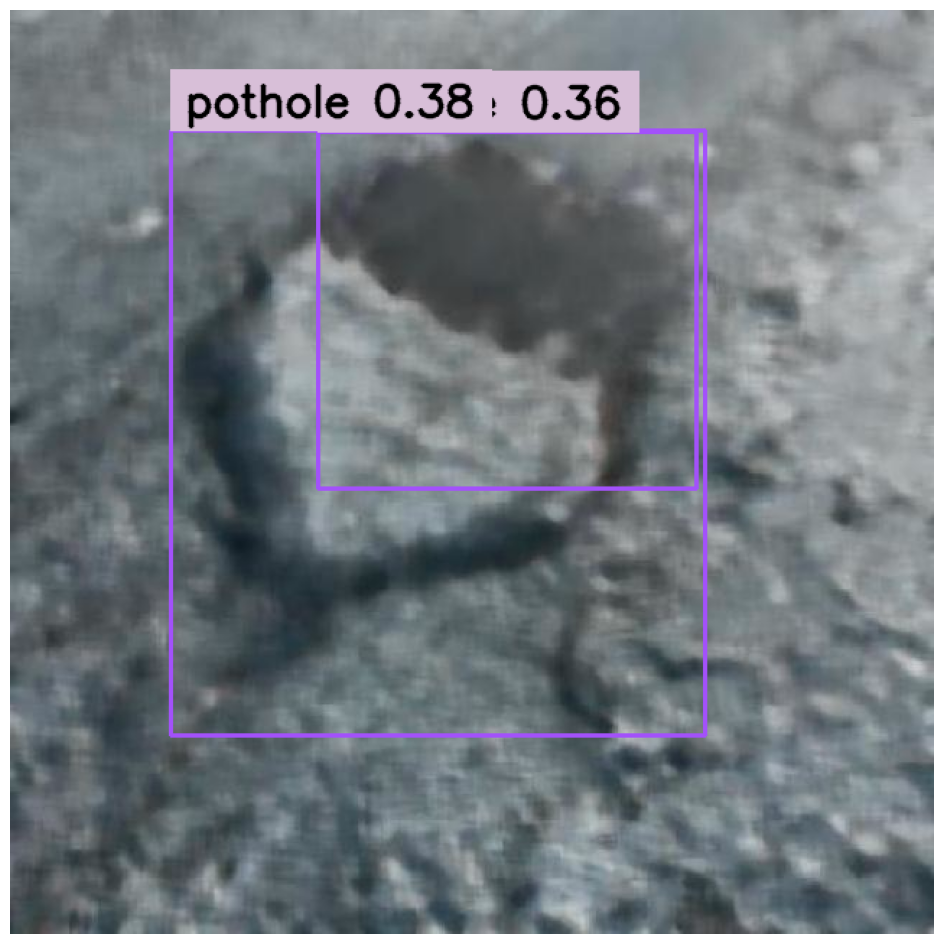

In [ ]:
import supervision as sv
import cv2, os

sample = os.listdir('unlabelled_images')[2]
image = cv2.imread(os.path.join('unlabelled_images', sample))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

detections = base_model.predict(image)

# Get class names from the model's ontology
class_names = list(base_model.ontology.classes())

# Initialize both BoxAnnotator and LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(
    text_thickness=2,
    text_scale=1,
    text_color=sv.Color.BLACK,
    color=sv.Color.from_hex("#D8BFD8"), # Purple color for labels
    text_padding=10
)

# Annotate the image with both boxes and labels
annotated_image = box_annotator.annotate(
    scene=image.copy(),
    detections=detections
)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=[f"{class_names[class_id]} {confidence:.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]
)

sv.plot_image(annotated_image)

## ⚠️ Best Practices
- Always manually review auto-labelled data
- Use auto-labelling only for clear, generic objects
- Treat auto-labels as *weak supervision*

## ✅ Key Takeaway
AutoDistill enables rapid dataset bootstrapping using foundation models.